# ProMo - A Speech Prosody Morphing library for Python

*An introduction and tutorial*

# Section 1.2: Pitch manipulation tutorial

<hr>
TABLE OF CONTENTS

**[Section 1.1: An introduction](tutorial1_1_intro_to_promo.ipynb)** (opens in a new notebook)

**Section 1.2: Pitch manipulation tutorial**
- <a href="#basic_manipulation">Basic pitch manipulations</a>
- <a href="#basic_manipulations_problems">Some problems with basic manipulations</a>
- <a href="#adjusting_for_duration">Adjusting for duration</a>
- <a href="#adjusting_for_pitch">Adjusting for pitch range and average pitch</a>
- <a href="#prosody_morph_with_textgrids">Morphing selective regions using textgrids</a>
- <a href="#intermediate_morphing">Intermediate morphing</a>




In [1]:
%matplotlib inline

In [2]:
# Settings things up
from os.path import join

import matplotlib.pyplot as plt
import numpy as np

import IPython
inputPath = join('..', 'examples', 'files')

from praatio import dataio

# Some convenience functions -- we'll be using these a lot
def pitchForPlots(pitchFN):
    pitchTier = dataio.open2DPointObject(pitchFN)
    x, y = zip(*pitchTier.pointList)
    return x, y

def doPlot(axis, title, pitchFN):
    axis.plot(*pitchForPlots(pitchFN))
    axis.set_title(title)
    axis.set_xlabel("time(s)")
    axis.set_ylabel("F0(hz)")
    
def displayAudio(audioTuple):
    for title, wavFN in audioTuple:
        print(title)
        IPython.display.display(IPython.display.Audio(wavFN))

<hr>
# A Tutorial

If you haven't already, please read section 1.1 for an introduction to ProMo and some conceptual basics behind doing pitch manipulations.  Here, we're going to jump right in and get our hands dirty with some code and data!

<hr>
<a id="basic_manipulation"></a>

### Basic Pitch Manipulations

The most basic manipulation is when the source values are replaced wholesale with other pre-defined values.  This requires just two things: a source file and target values.  In later examples, we will see how to generate intermediate manipulations or to selectively manipulate sections of a source file using sections of a target file.  Baby steps.

**The results of such basic manipulations aren't going to be useful except in very limited situations**

In [3]:
import io
import os
from os.path import join

from promo import f0_morph
from praatio import audioio
from praatio import dataio
from praatio import praat_scripts
from praatio import pitch_and_intensity

# We need to use absolute paths when using praatEXE
inputPath = os.path.abspath(join('..', 'examples', 'files'))
outputPath = os.path.abspath(join(inputPath, "pitch_tutorial_output"))
if not os.path.exists(outputPath):
    os.mkdir(outputPath)

########
# STEP 1: Load all the pre-defined parameters

# Pick your poison
praatEXE = r"C:\Praat.exe"  # Windows paths
#praatEXE = "/Applications/Praat.app/Contents/MacOS/Praat"  # Mac paths

# Audio file to manipulate
inputWavFN = "mary2.wav"

# Pitch file for manipulation
flatPitchFN = "mary2_flat_pitch.PitchTier"

# Final output wav file
outputWavFN = "mary2_flat_pitch.wav"
minPitch = 50
maxPitch = 350

########
# STEP 2: Create the target pitch contour
# To do this, we need to obtain pitch values at regular intervals
# Generally, you'd extract this information or use a stylized curve
# but here we'll generate an unnaturally flat pitch.  It will be noticably weird.
duration = audioio.getDuration(join(inputPath, inputWavFN))
frequency = 100.0
pitchVal = 100.0
pitchList = [(timeV / frequency, pitchVal) for timeV in range(int(duration * 100))]

targetPitchTier = dataio.PointObject2D(pitchList, dataio.PITCH, 0, duration)
targetPitchTier.save(join(outputPath, flatPitchFN))

########
# STEP 3: Do the resynthesis

praat_scripts.resynthesizePitch(praatEXE,
                                join(inputPath, inputWavFN),
                                join(outputPath, flatPitchFN),
                                join(outputPath, outputWavFN),
                                minPitch, maxPitch)
print("Let's take a look at the output:")

Let's take a look at the output:


In [4]:
displayAudio((("The original audio file:", join(inputPath, inputWavFN)),
              ("The new, resynthesized audio file (yikes!):", join(outputPath, outputWavFN))))

The original audio file:


The new, resynthesized audio file (yikes!):


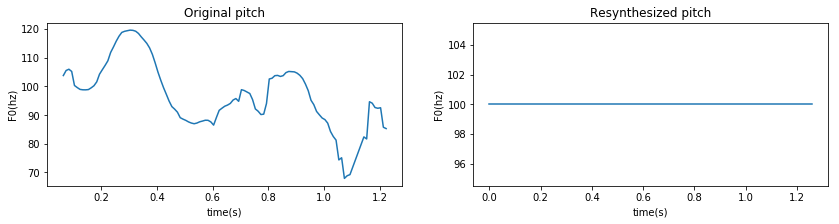

In [5]:
f, plotList = plt.subplots(1, 2, figsize=(14, 3))

x, y = zip(*targetPitchTier.pointList)

mary2PitchFN = "mary2.PitchTier"
pitch_and_intensity.extractPitchTier(join(inputPath, inputWavFN),
                                     join(outputPath, mary2PitchFN),
                                     praatEXE, minPitch, maxPitch)

doPlot(plotList[0], 'Original pitch', join(outputPath, mary2PitchFN)) 
doPlot(plotList[1], 'Resynthesized pitch', join(outputPath, flatPitchFN))

In some situations, it might make sense to algorithmically generate a pitch contour, as in the previous example.  But unless your data is simple or your pitch generating function sophisticated, the results might sound not unlike the flat pitch used in the previous resynthesis.  We'll approach this issue in the next example.

<hr>
<a id="basic_manipulations_problems"></a>
### Some problems with basic pitch manipulation

In the previous example, we resynthesized a recording using a flat pitch contour and it sounded terrible.  In this example, we show how to use a naturally produced pitch contour.

This comes with some important caveats, as will be discussed.


In [6]:
# Skipping everything above 'STEP 1' from the previous example

########
# STEP 1: Load all the pre-defined parameters

# Pick your poison
praatEXE = r"C:\Praat.exe"  # Windows paths
#praatEXE = "/Applications/Praat.app/Contents/MacOS/Praat"  # Mac paths

# Audio file to manipulate
inputWavFN = "mary2.wav"

# (*NEW*) Audio file supplying target pitch contour
targetWavFN = "mary1.wav"

# (*NEW*) Pitch file for manipulation
mary1PitchFN = "mary1.PitchTier"

# Final output wav file
outputWavFN = "mary2_to_mary1.wav"
minPitch = 50
maxPitch = 350

########
# STEP 2: Create the target pitch contour
# (*NEW*) Extracting pitch from target file
pitch_and_intensity.extractPitchTier(join(inputPath, targetWavFN),
                                     join(outputPath, mary1PitchFN),
                                     praatEXE, minPitch, maxPitch)

########
# STEP 3: Do the resynthesis

praat_scripts.resynthesizePitch(praatEXE,
                                join(inputPath, inputWavFN),
                                join(outputPath, mary1PitchFN),
                                join(outputPath, outputWavFN),
                                minPitch, maxPitch)
print("Let's take a look at the output:")

Let's take a look at the output:


In [7]:
displayAudio((("The original audio file:", join(inputPath, inputWavFN)),
              ("The target audio file:", join(inputPath, targetWavFN)),
              ("The new, resynthesized audio file (still yikes!):", join(outputPath, outputWavFN))))

The original audio file:


The target audio file:


The new, resynthesized audio file (still yikes!):


In some ways better than the output with flat pitch but in some cases worse.

**Why did the naturally produced pitch contour result in bad output?**

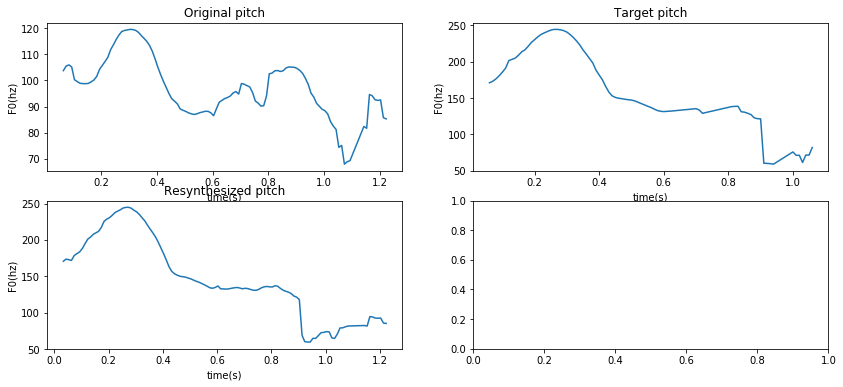

In [8]:
f, plotList = plt.subplots(2, 2, figsize=(14, 6))

resynthesizedPitchFN = "mary2_to_mary1.TextGrid"
pitch_and_intensity.extractPitchTier(join(outputPath, outputWavFN),
                                     join(outputPath, resynthesizedPitchFN),
                                     praatEXE, minPitch, maxPitch)

doPlot(plotList[0][0], 'Original pitch', join(outputPath, mary2PitchFN)) 
doPlot(plotList[0][1], 'Target pitch', join(outputPath, mary1PitchFN)) 
doPlot(plotList[1][0], 'Resynthesized pitch', join(outputPath, resynthesizedPitchFN)) 


So what happened?  Notice the axes.  The original pitch and the target pitch have different ranges for both the x axis (time) and the y axis (F0).  

Resynthesizing pitch in this way is problematic for several reasons:

1. If the target and source don't match much in content, you can get weird effects like pitch movements in improper places, etc.  In this case, the target and source do match in content, 

2. The audio files must match in length or else the target pitch will be clipped or there will be some remnenants of the source file's pitch after the end of the target pitch data.

3. Individuals have different average pitch and pitch range.  Men tend to have deeper voices (lower F0) with smaller differences between the pitch peaks and valleys than women, due to both physiological and cultural reasons.  However, even within gender there are large variations in pitch.

In the next example, we'll look at how to address the last two issues (the first issue is your responsibility when you're collecting your data).

<hr>
<a id="adjusting_for_duration"></a>
### Adjusting for duration

Let's repeat the previous procedure, but this time use the f0Morph() function.  Using it, we can correct for differences in duration, pitch range, and mean pitch.

We'll show this in two steps.  First, let's not bother with messing with pitch range or mean pitch.  Let's take care of duration first.  We don't need to do anything special, the f0Morph() function maps to the target pitch in relative time, so the source and target contours don't have to be the same length, and all pitch events will be preserved from both.

In [9]:
# Skipping everything above 'STEP 1' from the previous example

########
# STEP 1: Load all the pre-defined parameters

# Pick your poison
praatEXE = r"C:\Praat.exe"  # Windows paths
#praatEXE = "/Applications/Praat.app/Contents/MacOS/Praat"  # Mac paths

# Audio file to manipulate
inputWavFN = "mary2.wav"

# Audio file supplying target pitch contour
targetWavFN = "mary1.wav"

# Pitch file for manipulation
mary1PitchFN = "mary1.PitchTier"
mary2PitchFN = "mary2.PitchTier"

# Final output wav file
outputWavFN = "mary2_to_mary1.wav"
minPitch = 50
maxPitch = 350

# (*NEW*) The list of steps
# A lists of values between 0 and 1.0 where 0 corresponds to 0% morph (all source contour)
# and 1.0 corresponds to 100% morph (all target contour)
# For now, let's go with the simplest possible stepList:
stepList = [1.0, ]

########
# STEP 2: Load pitch data
# Notice that this time we're using extractPitch rather than extractPitchTier.
# The result is the same except the form of the output. extractPitch() returns
# a list of the form [(timeV1, pitchV1), (timeV2, pitchV2), ] whereas
# extractPitchTier() returns
fromPitchTier = pitch_and_intensity.extractPitchTier(join(inputPath, inputWavFN),
                                                     join(outputPath, mary2PitchFN),
                                                     praatEXE, minPitch,
                                                     maxPitch, forceRegenerate=False)

toPitchTier = pitch_and_intensity.extractPitchTier(join(inputPath, targetWavFN),
                                                   join(outputPath, mary1PitchFN),
                                                   praatEXE, minPitch,
                                                   maxPitch, forceRegenerate=False)

########
# STEP 3: Prepare the pitch regions
# (*NEW*) Wrap the pitch data into a list []
# extractPitch() returns a list of pitch data points
# f0 morph expects a list of lists, where each element of the list contains the pitch
# values for one region of the audio data. (e.g. the pitch values in fromPitch[0] would
# get morphed to the pitch values in toPitch[0] and the pitch values in fromPitch[1]
# would get morphed to the pitch values in toPitch[1], etc.)
# In this example, we only have 1 region containing all of our pitch data.  Thus:
fromPitchRegions = [fromPitchTier.pointList, ]
toPitchRegions = [toPitchTier.pointList, ]

########
# STEP 4: Run the morph process
f0_morph.f0Morph(fromWavFN=join(inputPath, inputWavFN),
                 pitchPath=outputPath,
                 stepList=stepList,
                 outputName="mary2_to_mary1_morph",
                 doPlotPitchSteps=False,
                 fromPitchData=fromPitchRegions,
                 toPitchData=toPitchRegions,
                 outputMinPitch=minPitch,
                 outputMaxPitch=maxPitch,
                 praatEXE=praatEXE)
print("Let's take a look at the output:")

Let's take a look at the output:


In [10]:
displayAudio((("The original audio file:", join(inputPath, inputWavFN)),
              ("The target audio file:", join(inputPath, targetWavFN)),
              ("The new, resynthesized audio file (better, but still yikes!):", join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_1.wav"))))

The original audio file:


The target audio file:


The new, resynthesized audio file (better, but still yikes!):


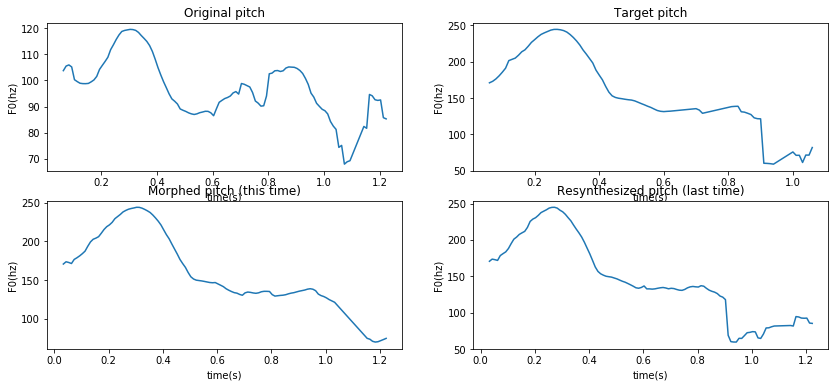

In [11]:
f, plotList = plt.subplots(2, 2, figsize=(14, 6))

pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_1.wav"),
                                     join(outputPath, "mary2_to_mary1_morph_1.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=False)

doPlot(plotList[0][0], 'Original pitch', join(outputPath, mary2PitchFN)) 
doPlot(plotList[0][1], 'Target pitch', join(outputPath, mary1PitchFN)) 
doPlot(plotList[1][0], 'Morphed pitch (this time)', join(outputPath, "mary2_to_mary1_morph_1.PitchTier"))
doPlot(plotList[1][1], 'Resynthesized pitch (last time)', join(outputPath, resynthesizedPitchFN))

<hr>
<a id="adjusting_for_pitch"></a>
### Adjusting for pitch range and average pitch

Now we're going to worry about pitch range and mean pitch.  It's really quite simple actually.  They take the form of two optional arguments to f0Morph(): **keepPitchRange** and **keepAveragePitch**

In [12]:
f0_morph.f0Morph(fromWavFN=join(inputPath, inputWavFN),
                 pitchPath=outputPath,
                 stepList=stepList,
                 outputName="mary2_to_mary1_morph_with_mary2_avg",
                 doPlotPitchSteps=False,
                 fromPitchData=fromPitchRegions,
                 toPitchData=toPitchRegions,
                 outputMinPitch=minPitch,
                 outputMaxPitch=maxPitch,
                 praatEXE=praatEXE,
                 keepPitchRange=False,  # (*NEW*)
                 keepAveragePitch=True)   # (*NEW*)

f0_morph.f0Morph(fromWavFN=join(inputPath, inputWavFN),
                 pitchPath=outputPath,
                 stepList=stepList,
                 outputName="mary2_to_mary1_morph_with_mary2_range",
                 doPlotPitchSteps=False,
                 fromPitchData=fromPitchRegions,
                 toPitchData=toPitchRegions,
                 outputMinPitch=minPitch,
                 outputMaxPitch=maxPitch,
                 praatEXE=praatEXE,
                 keepPitchRange=True,  # (*NEW*)
                 keepAveragePitch=False)   # (*NEW*)

f0_morph.f0Morph(fromWavFN=join(inputPath, inputWavFN),
                 pitchPath=outputPath,
                 stepList=stepList,
                 outputName="mary2_to_mary1_morph_with_mary2_all",
                 doPlotPitchSteps=False,
                 fromPitchData=fromPitchRegions,
                 toPitchData=toPitchRegions,
                 outputMinPitch=minPitch,
                 outputMaxPitch=maxPitch,
                 praatEXE=praatEXE,
                 keepPitchRange=True,  # (*NEW*)
                 keepAveragePitch=True)   # (*NEW*)

# And we'll go ahead and extract their pitchTiers now
pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_with_mary2_avg_1.wav"),
                                     join(outputPath, "mary2_to_mary1_morph_with_mary2_avg_1.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)
pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_with_mary2_range_1.wav"),
                                     join(outputPath, "mary2_to_mary1_morph_with_mary2_range_1.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)
pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_with_mary2_all_1.wav"),
                                     join(outputPath, "mary2_to_mary1_morph_with_mary2_all_1.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)
print("Let's take a look at the output:")

Let's take a look at the output:


In [13]:
displayAudio((
              ("The original audio file:", join(inputPath, inputWavFN)),
              ("The target audio file:", join(inputPath, targetWavFN)),
              ("The morphed audio from last time:", join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_1.wav")),
              ("With source average pitch:", join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_with_mary2_avg_1.wav")),
              ("With source range:", join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_with_mary2_range_1.wav")),
              ("With both source average pitch and range:", join(outputPath, "f0_resynthesized_wavs", "mary2_to_mary1_morph_with_mary2_all_1.wav")),
              ))

The original audio file:


The target audio file:


The morphed audio from last time:


With source average pitch:


With source range:


With both source average pitch and range:


So it seems that (at least in this case), the speaker's pitch range was the most important aspect of their voice.  I don't even hear a difference between the last two.

What do these look like?

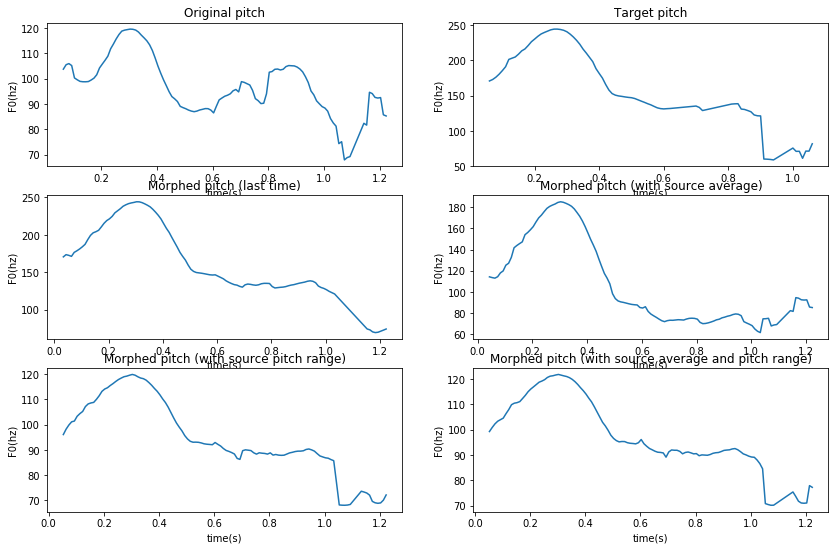

In [14]:
f, plotList = plt.subplots(3, 2, figsize=(14, 9))

doPlot(plotList[0][0], 'Original pitch', join(outputPath, mary2PitchFN)) 
doPlot(plotList[0][1], 'Target pitch', join(outputPath, mary1PitchFN)) 
doPlot(plotList[1][0], 'Morphed pitch (last time)', join(outputPath, "mary2_to_mary1_morph_1.PitchTier"))
doPlot(plotList[1][1], 'Morphed pitch (with source average)', join(outputPath, "mary2_to_mary1_morph_with_mary2_avg_1.PitchTier"))
doPlot(plotList[2][0], 'Morphed pitch (with source pitch range)', join(outputPath, "mary2_to_mary1_morph_with_mary2_range_1.PitchTier"))
doPlot(plotList[2][1], 'Morphed pitch (with source average and pitch range)', join(outputPath, "mary2_to_mary1_morph_with_mary2_all_1.PitchTier"))

<hr>
<a id='prosody_morph_with_textgrids'></a>
### Morphing selective regions using textgrids

The next wrinkle we're going to add in is the addition of TextGrids.  TextGrids contain timestamped annotations--intervals and points.  Anything could be annotated--the sentences, words, or phones being said, contextual information, stage directions, interruptions, whatever.  Using these annotations, we can selectively morph the pitch in one region to the pitch in another.

This code uses **PraatIO** a python library for working with speech transcripts.  You won't need to understand praatio to use this code but for more information on praatio and it's capabilities, you might find it useful to see it's homepage (a praatio tutorial is also available there).  [Praatio's page on GitHub](https://github.com/timmahrt/praatIO)

Back to the tutorial.

Remember how we wrapped the pitch data in a list?

In [15]:
fromPitchRegions = [fromPitchTier.pointList, ]
toPitchRegions = [toPitchTier.pointList, ]

In the earier examples we morphed one whole pitch tier to another.  However, we could split up the task into chunks--we could morph the first half of one to the first half of the other and the second half to the other second half.

We doing this by specifying more than one region in fromPitchRegions and toPitchRegions like so:

In [16]:
halfLen = int(len(fromPitchRegions)/2)
fromPitchRegions = [fromPitchTier.pointList[:halfLen], fromPitchTier.pointList[halfLen:]]
                    
halfLen = int(len(toPitchRegions)/2)                    
toPitchRegions = [toPitchTier.pointList[:halfLen], toPitchTier.pointList[halfLen:]]

**Why split up the regions to morph in the first place?**  Although f0Morph() can work on files of different lengths, if there is a mismatch between the timing of the content being said, undesired results can occur.  Consider a few cases:

* He likes to eat pickles.

* She likes to eat oranges, he said.

In a case like this, we might only want to morph the segments that are structurally similar.  We could omit 'she said' from the morph process.

* Constantinople was big.

* Paris is enormous.

The inbalance in syllables between the subject and the object may lead to segments of the mapped contour falling in places it wouldn't naturally occur on.

In scenarios like these, we can create textgrid annotations that mark the regions we'd like to map.  These could be arbitrary regions, that we annotate, or could be something more typical like utterance, word, or phone-level annotations.


In terms of the code, a special function will pull out the pitch samples at those times, but otherwise the morph process is as we've seen.  Let's try an example

In [17]:
# This is a complete example that don't require the earlier
# segments of this tutorial to run.
import io
import os
from os.path import join

from promo import f0_morph
from praatio import audioio
from praatio import dataio
from praatio import praat_scripts
from praatio import pitch_and_intensity

# We need to use absolute paths when using praatEXE
inputPath = os.path.abspath(join('..', 'examples', 'files'))
outputPath = os.path.abspath(join(inputPath, "pitch_tutorial_output"))
if not os.path.exists(outputPath):
    os.mkdir(outputPath)

########
# STEP 1: Load all the pre-defined parameters

# Pick your poison
praatEXE = r"C:\Praat.exe"  # Windows paths
#praatEXE = "/Applications/Praat.app/Contents/MacOS/Praat"  # Mac paths
minPitch = 50
maxPitch = 350
stepList = [1.0, ]

########
# STEP 2: Load pitch data
fromPitchTier = pitch_and_intensity.extractPitchTier(join(inputPath, "oranges.wav"),
                                                     join(outputPath, "oranges.PitchTier"),
                                                     praatEXE, minPitch,
                                                     maxPitch, forceRegenerate=True)

toPitchTier = pitch_and_intensity.extractPitchTier(join(inputPath, "pickles.wav"),
                                                   join(outputPath, "pickles.PitchTier"),
                                                   praatEXE, minPitch,
                                                   maxPitch, forceRegenerate=True)

########
# STEP 3: Prepare the pitch regions
# (*NEW*) -- using getPitchForIntervals()
tierName = "utterances"
fromTGFN = join(inputPath, "oranges.TextGrid")
toTGFN = join(inputPath, "pickles.TextGrid")
fromPitchRegions = f0_morph.getPitchForIntervals(fromPitchTier.pointList, fromTGFN, tierName)
toPitchRegions = f0_morph.getPitchForIntervals(toPitchTier.pointList, toTGFN, tierName)

########
# STEP 4: Run the morph process
f0_morph.f0Morph(fromWavFN=join(inputPath, "oranges.wav"),
                 pitchPath=outputPath,
                 stepList=stepList,
                 outputName="oranges_to_pickles_with_textgrids",
                 doPlotPitchSteps=False,
                 fromPitchData=fromPitchRegions,
                 toPitchData=toPitchRegions,
                 outputMinPitch=minPitch,
                 outputMaxPitch=maxPitch,
                 praatEXE=praatEXE,
                 keepPitchRange=False,
                 keepAveragePitch=False,
                 sourcePitchDataList=fromPitchTier.pointList)  
                # (*NEW*) If you aren't manipulating the whole pitch contour, specify the source
                # pitch contour with *sourcePitchDataList* and it will sample from any regions
                # not in fromPitchData
                

# And we'll go ahead and extract the pitchTier now
pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "oranges_to_pickles_with_textgrids_1.wav"),
                                     join(outputPath, "oranges_to_pickles_with_textgrids_1.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)


# Let's also morph the files without a textgrid for comparison
fromPitchRegions = [fromPitchTier.pointList, ]
toPitchRegions = [toPitchTier.pointList, ]
f0_morph.f0Morph(fromWavFN=join(inputPath, "oranges.wav"),
                 pitchPath=outputPath,
                 stepList=stepList,
                 outputName="oranges_to_pickles",
                 doPlotPitchSteps=False,
                 fromPitchData=fromPitchRegions,
                 toPitchData=toPitchRegions,
                 outputMinPitch=minPitch,
                 outputMaxPitch=maxPitch,
                 praatEXE=praatEXE,
                 keepPitchRange=False,
                 keepAveragePitch=False)

pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "oranges_to_pickles_1.wav"),
                                     join(outputPath, "oranges_to_pickles_1.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)

print("Let's take a look at the output:")

Let's take a look at the output:


In [18]:
displayAudio((
              ("The original audio file:", join(inputPath, "oranges.wav")),
              ("The target audio file:", join(inputPath, "pickles.wav")),
              ("Morphed without textgrids:", join(outputPath, "f0_resynthesized_wavs", "oranges_to_pickles_1.wav")),
              ("Morphed with textgrids:", join(outputPath, "f0_resynthesized_wavs", "oranges_to_pickles_with_textgrids_1.wav")),
              ))

The original audio file:


The target audio file:


Morphed without textgrids:


Morphed with textgrids:


Hear the difference on "he said" between the last two files?

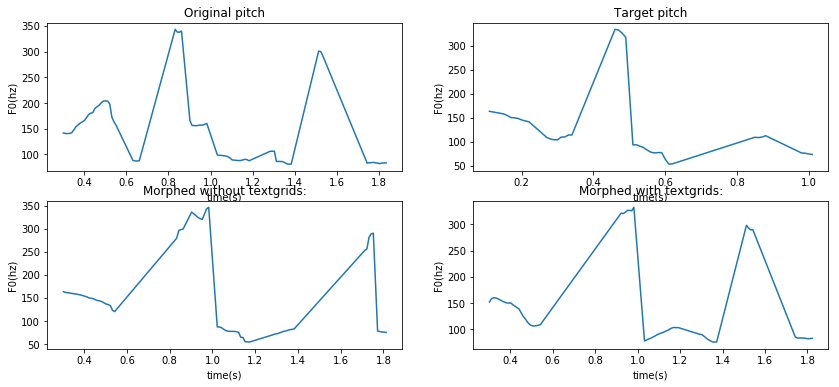

In [19]:
f, plotList = plt.subplots(2, 2, figsize=(14, 6))

doPlot(plotList[0][0], 'Original pitch', join(outputPath, "oranges.PitchTier")) 
doPlot(plotList[0][1], 'Target pitch', join(outputPath, "pickles.PitchTier")) 
doPlot(plotList[1][0], 'Morphed without textgrids:', join(outputPath, "oranges_to_pickles_1.PitchTier"))
doPlot(plotList[1][1], 'Morphed with textgrids:', join(outputPath, "oranges_to_pickles_with_textgrids_1.PitchTier"))

With the the textgrid method, we get the target pitch over the first portion "she like's oranges" but we get the original pitch of "he said".  Cool!

One thing you might have noticed.  There is some funky pitch over the region 'he said' in the pitch track for "Morphed without textgrids."  It doesn't correspond to the target or source pitch.  I was surprised myself--but I opened it up in praat to see what was going on.  There isn't a lot of voicing in that region and the pitch tracker seemed to struggle a bit.  I'd chalk it up to a pitch error.  Going into more detail about pitch errors is the topic for another tutorial.

<hr>
<a id='intermediate_morphing'></a>
### Intermediate morphing

So far, we've looked at examples that replace the source pitch contour with the target pitch contour.  But what if we wanted something inbetween the source and the target?  It might be difficult to think of a situation where we would want such recordings but such 'intermediate' output is commonly used in speech perception experiments.

Earlier we used the code snippet:

In [20]:
stepList = [1.0, ]

Values in stepList should range between 0.0 and 1.0 where 0.0 means the output will have a contour that is 100% from the source file and 1.0 means the output will have a contour that is 100% from the target file.  One output file will be generated for each step in the stepList.

Let's see an example:

In [21]:
# We'll use the same setup as in the previous example, which used textgrids
stepList = [0.0, 0.33, 0.66, 1.0]
minPitch = 75
maxPitch = 350


fromPitchTier = pitch_and_intensity.extractPitchTier(join(inputPath, "carrots1.wav"),
                                                     join(outputPath, "carrots1.PitchTier"),
                                                     praatEXE, minPitch,
                                                     maxPitch, forceRegenerate=True)

toPitchTier = pitch_and_intensity.extractPitchTier(join(inputPath, "carrots2.wav"),
                                                   join(outputPath, "carrots2.PitchTier"),
                                                   praatEXE, minPitch,
                                                   maxPitch, forceRegenerate=True)

tierName = "words"
fromTGFN = join(inputPath, "carrots1.TextGrid")
toTGFN = join(inputPath, "carrots2.TextGrid")
fromPitchRegions = f0_morph.getPitchForIntervals(fromPitchTier.pointList, fromTGFN, tierName)
toPitchRegions = f0_morph.getPitchForIntervals(toPitchTier.pointList, toTGFN, tierName)

########
# STEP 4: Run the morph process
f0_morph.f0Morph(fromWavFN=join(inputPath, "carrots1.wav"),
                 pitchPath=outputPath,
                 stepList=stepList,
                 outputName="carrots1_to_carrots2_morph",
                 doPlotPitchSteps=False,
                 fromPitchData=fromPitchRegions,
                 toPitchData=toPitchRegions,
                 outputMinPitch=minPitch,
                 outputMaxPitch=maxPitch,
                 praatEXE=praatEXE,
                 keepPitchRange=False,
                 keepAveragePitch=False)

# And we'll go ahead and extract the pitchTier now
pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_0.wav"),
                                     join(outputPath, "carrots1_to_carrots2_morph_0.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)

pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_0.33.wav"),
                                     join(outputPath, "carrots1_to_carrots2_morph_0.33.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)

pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_0.66.wav"),
                                     join(outputPath, "carrots1_to_carrots2_morph_0.66.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)

pitch_and_intensity.extractPitchTier(join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_1.wav"),
                                     join(outputPath, "carrots1_to_carrots2_morph_1.PitchTier"),
                                     praatEXE, minPitch,
                                     maxPitch, forceRegenerate=True)

print("Let's take a look at the output:")

Let's take a look at the output:


In [22]:
displayAudio((
              ("The original audio file:", join(inputPath, "carrots1.wav")),
              ("The target audio file:", join(inputPath, "carrots2.wav")),
              ("100% source, 0% target:", join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_0.wav")),
              ("60% source, 30% target:", join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_0.33.wav")),
              ("30% source, 60% target:", join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_0.66.wav")),
              ("0% source, 100% target:", join(outputPath, "f0_resynthesized_wavs", "carrots1_to_carrots2_morph_1.wav")),
              ))

The original audio file:


The target audio file:


100% source, 0% target:


60% source, 30% target:


30% source, 60% target:


0% source, 100% target:


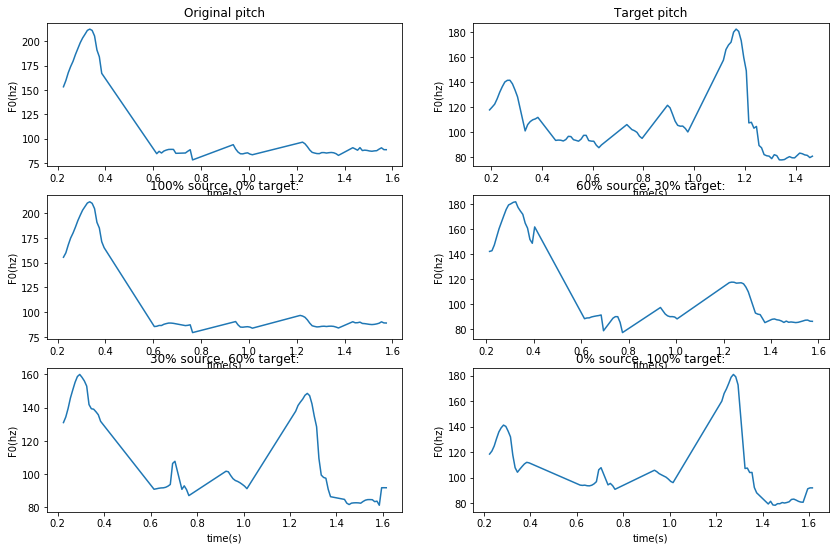

In [23]:
f, plotList = plt.subplots(3, 2, figsize=(14, 9))

doPlot(plotList[0][0], 'Original pitch', join(outputPath, "carrots1.PitchTier")) 
doPlot(plotList[0][1], 'Target pitch', join(outputPath, "carrots2.PitchTier")) 
doPlot(plotList[1][0], '100% source, 0% target:', join(outputPath, "carrots1_to_carrots2_morph_0.PitchTier"))
doPlot(plotList[1][1], '60% source, 30% target:', join(outputPath, "carrots1_to_carrots2_morph_0.33.PitchTier"))
doPlot(plotList[2][0], '30% source, 60% target:', join(outputPath, "carrots1_to_carrots2_morph_0.66.PitchTier"))
doPlot(plotList[2][1], '0% source, 100% target:', join(outputPath, "carrots1_to_carrots2_morph_1.PitchTier"))

In the original utterance, 'carrots' has *focus*--which we can by the pitch accent over it.  In the target sentence, 'vitamins' has *focus*--which we can tell by the pitch accent over it.  With the intermediate morphing, we can see the strongest pitch contour gradually change from 'carrots' to 'vitamins'.

If you listen to the audio, the morphed production doesn't sound the same as the target sentence, even though they have similar pitch accent.  This is because of other differences in pronunciations, like the way the consonants and vowels were enunciated.  ProMo can't help with those sorts of issues.

<hr>

That wraps up the tutorial on pitch morphing with promo.